In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Libraries

# DS 
import os
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns

# PLOTLY
import plotly.offline as po
import plotly.graph_objs as go

# SKLEARN
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              AdaBoostRegressor,
                              RandomForestRegressor,
                              RandomForestClassifier)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, confusion_matrix, accuracy_score, plot_roc_curve
from sklearn.svm import SVC
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

# Aesthetic Plots
import mplcyberpunk
plt.style.use('cyberpunk')
%matplotlib inline

In [3]:
# Modules
from src.data_clean import *
from src.grid_search import *

In [4]:
# GLOBAL VARS
FSIZE = (12, 8)

In [5]:
# Helper Functions
def get_score(model, X, y) -> tuple:
    mse = np.mean(cross_val_score(model, X, y, scoring=make_scorer(mean_squared_error)))
    r2 = np.mean(cross_val_score(model, X, y, scoring=make_scorer(r2_score)))
    acc = np.mean(cross_val_score(model, X, y, scoring="accuracy"))
    print(f"""{model.__class__.__name__}     Train CV | MSE: {mse} | R2: {r2} | Acc: {acc}""")
    return mse, r2, acc
def display_score_metrics(model, y_pred, y_test) -> tuple:
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"""{model.__class__.__name__}     Train CV | MSE: {mse} | R2: {r2} | Acc: {acc}""")
    return mse, r2, acc

def plot_ROC(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)
    y_predproba = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test.values, y_predproba[:,1])
    auc = roc_auc_score(y_test,y_pred)
    
    fig,ax = plt.subplots(1,1,figsize=(12,10))
    ax.plot(fpr,tpr,label='{}: {}'.format(model.__class__.__name__, auc), marker='*', color='green')
    ax.plot([0,1],[0,1], 'k:')
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC Curve for {} Model".format(modelname))
    ax.legend(loc='lower right')


# Create Basline Models

In [6]:
# Read and Clean CSV
churn = data_cleaner(pd.read_csv("data/churn_train.csv"))

In [7]:
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,target,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,6.94,5.0,5.000000,1.00,1.0,0.0,0.0,0.0,100.0,1.0,0.0,0.0,1.0,0.0
1,8.06,5.0,5.000000,1.00,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,21.50,4.0,4.601697,1.00,1.0,0.0,1.0,1.0,100.0,0.0,0.0,1.0,0.0,1.0
3,9.46,5.0,4.601697,2.75,1.0,100.0,1.0,0.0,100.0,0.0,0.0,1.0,1.0,0.0
4,13.77,5.0,4.601697,1.00,1.0,0.0,0.0,0.0,100.0,0.0,0.0,1.0,0.0,1.0


In [8]:
# Create X, y arrays from dataframe
X = churn
y = churn.pop("target")

In [9]:
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Random Forest Classifier

In [10]:
# Create Random Forest Model
model_rf = RandomForestClassifier(
                            oob_score=True,
                            max_features=3,
)

In [11]:
# Fit Data
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

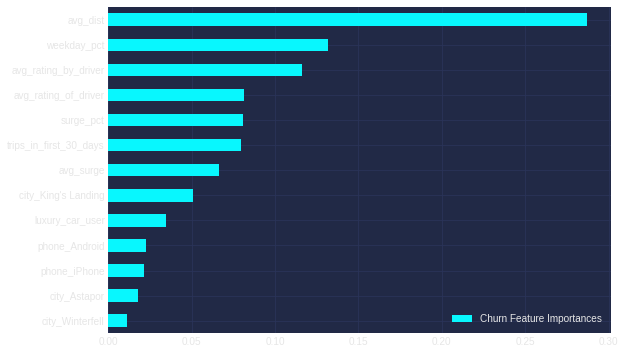

In [12]:
# Feature Importances

# See and plot feature importances 
feat_scores = pd.DataFrame({'Churn Feature Importances' : model_rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Churn Feature Importances')
feat_scores.plot(kind='barh', figsize=(9, 6))

In [13]:
# Out of Bag Error
model_rf.oob_score_

0.7622666666666666

In [14]:
# Prediciton
# model_rf.predict(X)

#### Random Forest Performance

In [15]:
# get_score(model_rf, X_train, y_train)

## Gradient Boosting Classifier

In [16]:
# Create Gradient Boosting Model
model_gb = GradientBoostingClassifier(learning_rate=0.1,
                                      n_estimators=100,
                                      random_state=1)

In [17]:
# Fit Model
model_gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [18]:
# Prediction
y_pred_gb = model_gb.predict(X_test)

In [19]:
# Feature Importances
feat_scores = pd.DataFrame({'Churn Feature Importances GDBC' : model_gb.feature_importances_}, index=X.columns)
feat_scores = feat_scores.sort_values(by='Churn Feature Importances GDBC')

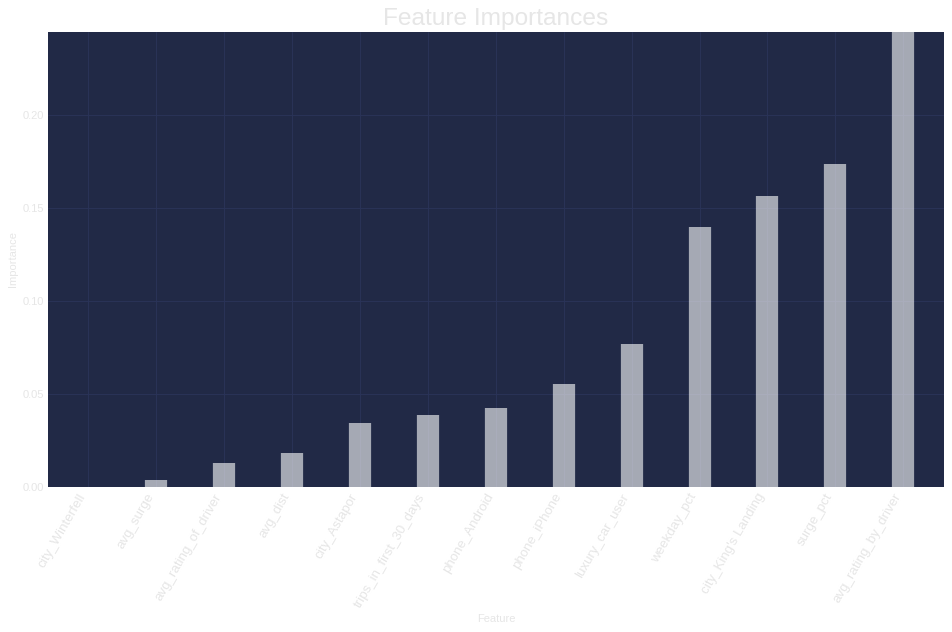

In [20]:
# See and plot feature importances 

fig, ax = plt.subplots(figsize=FSIZE, dpi=80, )
ax.vlines(x=range(1, feat_scores.size + 1), ymin=0, ymax=(feat_scores["Churn Feature Importances GDBC"]), color="white", alpha=0.6, linewidth=20, edgecolors="white")


# Title, Label, Ticks and Ylim
ax.set_title('Feature Importances', fontdict={'size':22})
ax.set(xlabel='Feature', ylim=(0, np.max(feat_scores["Churn Feature Importances GDBC"])))
ax.set(ylabel='Importance')

plt.xticks(range(1, feat_scores.size + 1), feat_scores.index, rotation=60, horizontalalignment='right', fontsize=12)

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

fig.tight_layout()
plt.show()

## Sample Tree Plot 

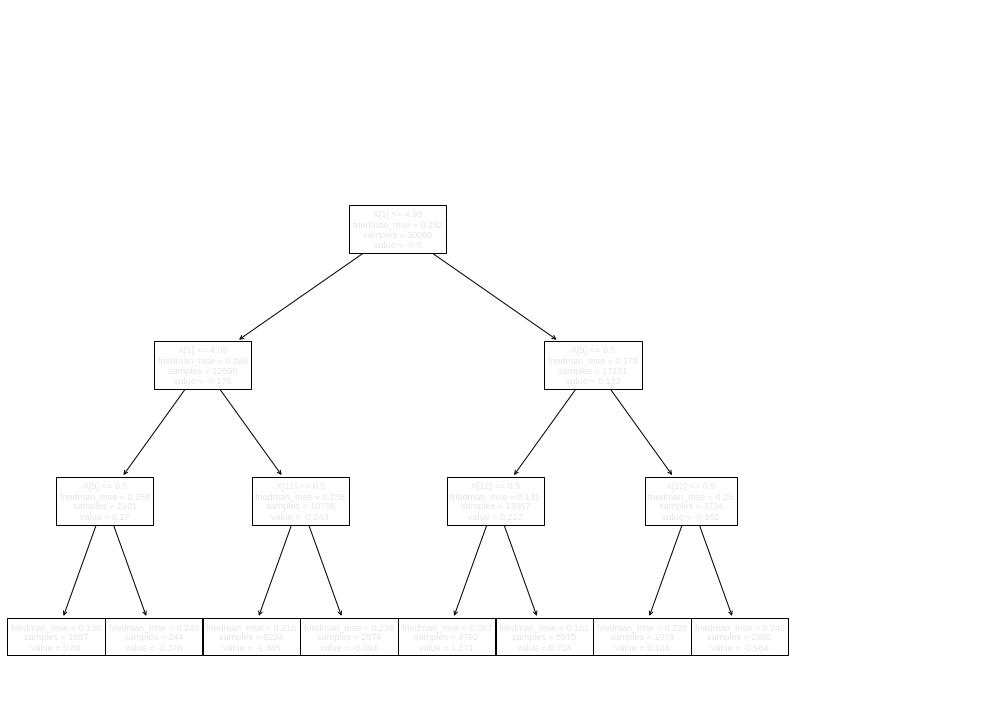

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))
tree_1 = model_gb.estimators_[0][0]
tree_1_plot = plot_tree(tree_1, ax=ax)

fig.tight_layout()
plt.show()

## Confusion Matrix

In [22]:
# Confusion Matrix GBC
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred_gb).flatten()
true_neg, false_pos, false_neg, true_pos

(2386, 1237, 886, 5491)

| -        |       Predicted Negative      |  Predicted Positive |
| ------------- |:-------------:| -----:|
| Actual Negative | 5409 (TN)  | 890 (FP)
| Actual Positive | 1308 (FN) | 2393 (TP)

In [23]:
# Precision GBC
precision_before = true_pos / (true_pos + false_pos)
precision_before

0.816141498216409

In [24]:
# Recall GBC
recall_before = true_pos / (true_pos + false_neg)
recall_before

0.8610631958601224

#### Gradient Boosting Classifier Peformance

In [25]:
get_score(model_gb, X_train, y_train)

GradientBoostingClassifier     Train CV | MSE: 0.20706666666666668 | R2: 0.10873358233389101 | Acc: 0.7929333333333333


(0.20706666666666668, 0.10873358233389101, 0.7929333333333333)

## Gradient Boosting Regression

In [26]:
model_gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls',
                                 n_estimators=100, random_state=1)

#### Gradient Boosting Regression Peformance

In [27]:
# get_score(model_gbr, X_train, y_train)

#### Gradient Boosting Grid Search

> Find best hyper-parameters for Gradient Boosting

In [28]:
# Create Grid Search
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [100],
                          'random_state': [1]}
gdbr_best_params, gdbr_best_model = gridsearch_with_output(GradientBoostingRegressor(), 
                                                           gradient_boosting_grid, 
                                                           X_train, y_train)
print("\nComparing model with gridsearch params to initial model on Test set.")
model_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.6min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
learning_rate        | 0.1      | [0.1, 0.05, 0.02, 0.01]
max_depth            | 6        | [2, 4, 6]
min_samples_leaf     | 10       | [1, 2, 5, 10]
max_features         | 0.3      | [1.0, 0.3, 0.1]
n_estimators         | 100      | [100]
random_state         | 1        | [1]

Comparing model with gridsearch params to initial model on Test set.


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
display_default_and_gsearch_model_results(model_gbr, gdbr_best_model, X_test, y_test)

Results for GradientBoosting
Gridsearched model mse: 0.147 | r2: 0.365
     Default model mse: 0.149 | r2: 0.354


#### Grid Search Best Parameters

In [30]:
gdbr_best_params

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.3,
 'min_samples_leaf': 10,
 'n_estimators': 100,
 'random_state': 1}

In [31]:
y_pred_gdbr_best = gdbr_best_model.predict(X_test)

#### Gradient Boosting Regression Peformance (POST GRID SEARCH)

> Baseline Threshold: 0.5

In [32]:
display_score_metrics(gdbr_best_model, (y_pred_gdbr_best >= 0.5).astype(int), y_test)

GradientBoostingRegressor     Train CV | MSE: 0.2092 | R2: 0.09452403019390121 | Acc: 0.7908


(0.2092, 0.09452403019390121, 0.7908)

> Baseline Threshold: 0.7

In [33]:
display_score_metrics(gdbr_best_model, (y_pred_gdbr_best >= 0.7).astype(int), y_test)

GradientBoostingRegressor     Train CV | MSE: 0.2454 | R2: -0.06215967012627455 | Acc: 0.7546


(0.2454, -0.06215967012627455, 0.7546)

> Baseline Threshold: 0.3

In [34]:
display_score_metrics(gdbr_best_model, (y_pred_gdbr_best >= 0.3).astype(int), y_test)

GradientBoostingRegressor     Train CV | MSE: 0.2347 | R2: -0.01584708467252094 | Acc: 0.7653


(0.2347, -0.01584708467252094, 0.7653)

#### Confusion Matrix

In [35]:
# Confusion Matrix GBR
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, (y_pred_gdbr_best >= 0.5).astype(int)).flatten()
true_neg, false_pos, false_neg, true_pos

(2384, 1239, 853, 5524)

BEFORE

| -        |       Predicted Negative      |  Predicted Positive |
| ------------- |:-------------:| -----:|
| Actual Negative | 2394 (TN)  | 1274 (FP)
| Actual Positive | 4244 (FN) | 2088 (TP)


(2394, 1274, 4244, 2088)

AFTER


| -        |       Predicted Negative      |  Predicted Positive |
| ------------- |:-------------:| -----:|
| Actual Negative | 2423 (TN)  | 1245 (FP)
| Actual Positive | 808 (FN) | 5524 (TP)

(2423, 1245, 808, 5524)

PRECISION / RECALL (BEFORE and AFTER)


| -        |       Precision      |  Recall |
| ------------- |:-------------:| -----:|
| BEFORE | 0.62  | 0.32
| AFTER | 0.81 | 0.87

(2423, 1245, 808, 5524)

In [36]:
# Precision GBC
precision_after = true_pos / (true_pos + false_pos)
precision_after

0.816797279313914

In [37]:
# Recall GBC
recall_after = true_pos / (true_pos + false_neg)
recall_after

0.8662380429669123

In [38]:
(precision_before, recall_before), (precision_after, recall_after)

((0.816141498216409, 0.8610631958601224),
 (0.816797279313914, 0.8662380429669123))